# Pneumonia Detection using X-Ray (PyTorch) - 2020
#### This Machine Learning model uses Convolutional Neural Network to detect if the X-Ray is infected with Pneumonia.

In [32]:
from pathlib import Path
import os
import glob
import cv2
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [33]:
project_name = 'Chest-XRay-Pneumonia-Project'

* ### **Exploring dataset**

In [34]:
data_dir = Path('../input/chest-xray-pneumonia/chest_xray/')
test_p = data_dir/'test/PNEUMONIA'
test_n = data_dir/'test/NORMAL'

train_p = data_dir/'train/PNEUMONIA'
train_n = data_dir/'train/NORMAL'

val_p = data_dir/'val/PNEUMONIA'
val_n = data_dir/'val/NORMAL'

In [35]:
!ls "{train_p}" | head

person1000_bacteria_2931.jpeg
person1000_virus_1681.jpeg
person1001_bacteria_2932.jpeg
person1002_bacteria_2933.jpeg
person1003_bacteria_2934.jpeg
person1003_virus_1685.jpeg
person1004_bacteria_2935.jpeg
person1004_virus_1686.jpeg
person1005_bacteria_2936.jpeg
person1005_virus_1688.jpeg
ls: write error: Broken pipe


In [36]:
!ls "{train_n}" | head

IM-0115-0001.jpeg
IM-0117-0001.jpeg
IM-0119-0001.jpeg
IM-0122-0001.jpeg
IM-0125-0001.jpeg
IM-0127-0001.jpeg
IM-0128-0001.jpeg
IM-0129-0001.jpeg
IM-0131-0001.jpeg
IM-0133-0001.jpeg
ls: write error: Broken pipe


In [37]:
# Get the list of all the images
train_pneumonia = train_p.glob('*.jpeg')
train_normal = train_n.glob('*.jpeg')

test_pneumonia = test_p.glob('*.jpeg')
test_normal = test_n.glob('*.jpeg')

val_pneumonia = val_p.glob('*.jpeg')
val_normal = val_n.glob('*.jpeg')

train_data = []
test_data = []
val_data = []

for i in train_pneumonia:
    train_data.append((i,1))
for i in train_normal:
    train_data.append((i,0))
    
for i in test_pneumonia:
    test_data.append((i,1))
for i in test_normal:
    test_data.append((i,0))

for i in val_pneumonia:
    val_data.append((i,1))
for i in val_normal:
    val_data.append((i,0))

# Transform array to Pandas Dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.,random_state=15).reset_index(drop=True)

test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)
test_data = test_data.sample(frac=1.,random_state=15).reset_index(drop=True)

val_data = pd.DataFrame(val_data, columns=['image', 'label'],index=None)
val_data = val_data.sample(frac=1.,random_state=15).reset_index(drop=True)

In [38]:
len(train_data), len(test_data), len(val_data)

(5216, 624, 16)

In [39]:
labels = {
    0: 'Normal',
    1: 'Pneumonia'
}

In [40]:
main_data = pd.concat([train_data,val_data], ignore_index=True)
main_data = main_data.sample(frac=1.,random_state=17).reset_index(drop=True)

1    3883
0    1349
Name: label, dtype: int64


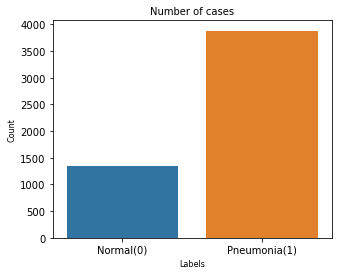

In [41]:
cases_count = main_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=10)
plt.xlabel('Labels', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

* ### Preparing dataset for training


In [42]:
class PneumoniaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_fname, img_label = row['image'], row['label']
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        return img, img_label

In [43]:
np.random.seed(42)
msk = np.random.rand(len(main_data)) < 0.7

train_df = main_data[msk].reset_index()
val_df = main_data[~msk].reset_index()

In [44]:
train_transform = tt.Compose([tt.Resize((256,256)),
                             tt.RandomAffine(30),
                             tt.ColorJitter(),
                             tt.ToTensor()])
val_transform = tt.Compose([tt.Resize((256,256)),
                           tt.ToTensor()])

In [45]:
train_ds = PneumoniaDataset(train_df, transform=train_transform)
val_ds = PneumoniaDataset(val_df, transform=val_transform)
len(train_ds), len(val_ds)

(3696, 1536)

In [46]:
batch_size = 16

In [47]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)

In [48]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=4).permute(1, 2, 0))
        break

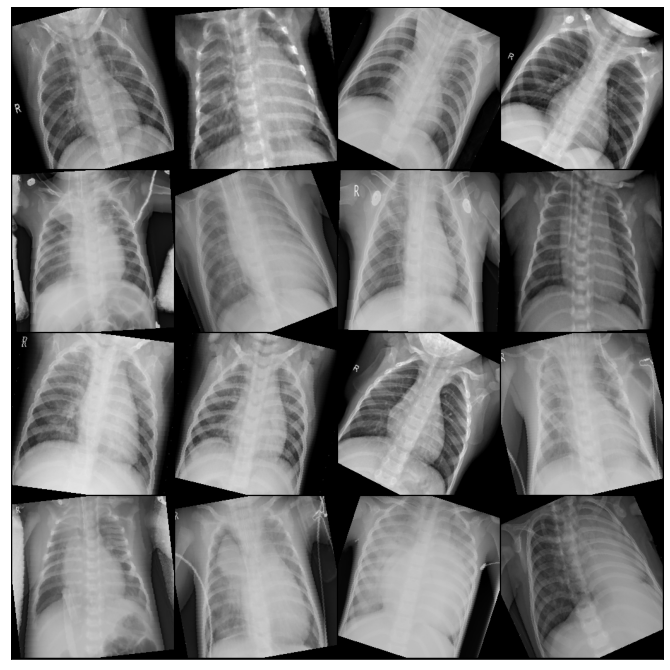

In [49]:
show_batch(train_dl)

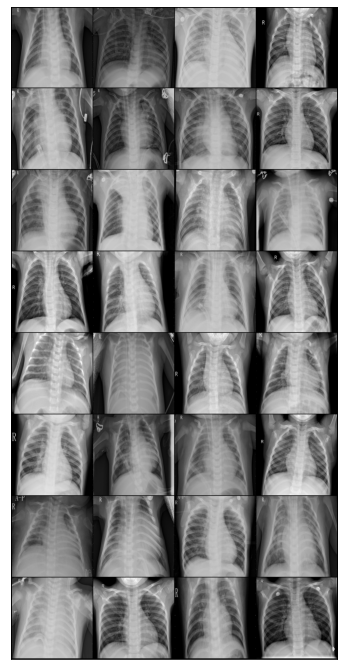

In [50]:
show_batch(val_dl)

In [51]:
img, label = train_ds[0]
print(img.shape, label)
img

torch.Size([3, 256, 256]) 1


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [52]:
def show_example(img, label):
    #print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

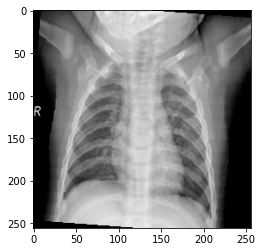

In [53]:
show_example(*train_ds[25])

* ### Using GPU

In [54]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [55]:
device = get_default_device()
device

device(type='cuda')

In [56]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

* ### Training the model

In [57]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [58]:
class PneumoniaClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [59]:
class PneumoniaResnet(PneumoniaClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Dropout(0.5)
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [60]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [61]:
model = to_device(PneumoniaResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [62]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([16, 3, 256, 256])
out.shape: torch.Size([16, 2])
out[0]: tensor([0.8963, 0.6542], device='cuda:0', grad_fn=<SelectBackward>)


In [63]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.5901103019714355, 'val_score': 0.7376301884651184}]

In [64]:
model.freeze()

In [65]:
epochs = 5
max_lr = 30e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [66]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.0023, train_loss: 0.2375, val_loss: 1.7328, val_score: 0.3704
Epoch [1], last_lr: 0.0029, train_loss: 0.1928, val_loss: 0.1835, val_score: 0.9303
Epoch [2], last_lr: 0.0018, train_loss: 0.1531, val_loss: 0.1116, val_score: 0.9642
Epoch [3], last_lr: 0.0006, train_loss: 0.1184, val_loss: 0.0654, val_score: 0.9753
Epoch [4], last_lr: 0.0000, train_loss: 0.0775, val_loss: 0.0518, val_score: 0.9811
CPU times: user 1min 1s, sys: 7.6 s, total: 1min 8s
Wall time: 5min 41s


In [67]:
model.unfreeze()

In [68]:
%%time
history += fit_one_cycle(epochs, 1e-5, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.0000, train_loss: 0.0682, val_loss: 0.0541, val_score: 0.9772
Epoch [1], last_lr: 0.0000, train_loss: 0.0735, val_loss: 0.0499, val_score: 0.9811
Epoch [2], last_lr: 0.0000, train_loss: 0.0612, val_loss: 0.0493, val_score: 0.9805
Epoch [3], last_lr: 0.0000, train_loss: 0.0603, val_loss: 0.0487, val_score: 0.9798
Epoch [4], last_lr: 0.0000, train_loss: 0.0617, val_loss: 0.0477, val_score: 0.9811
CPU times: user 58.9 s, sys: 7.26 s, total: 1min 6s
Wall time: 5min 23s


* ### Testing Model

In [69]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

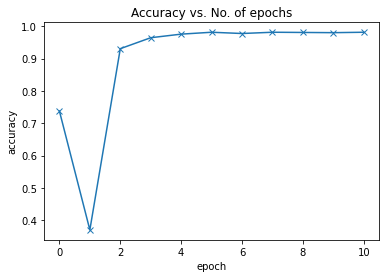

In [70]:
plot_accuracies(history)

In [71]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

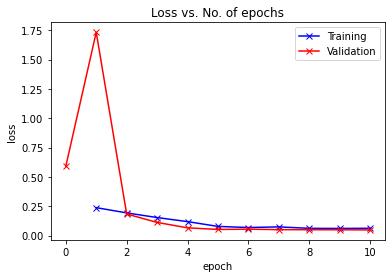

In [72]:
plot_losses(history)

In [73]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

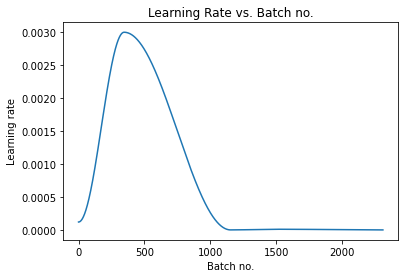

In [74]:
plot_lrs(history)

In [75]:
test_dataset = PneumoniaDataset(test_data, transform=val_transform)
test_dl = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [76]:
len(test_dataset)

624

In [77]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

Label: Normal , Predicted: Normal


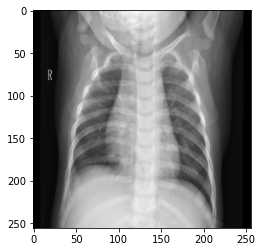

In [89]:
img, label = test_dataset[526]
plt.imshow(img[0], cmap='gray')
print('Label:', labels[label], ', Predicted:', labels[predict_image(img, model)])

Label: Pneumonia , Predicted: Pneumonia


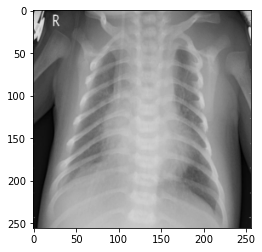

In [79]:
img, label = test_dataset[250]
plt.imshow(img[0], cmap='gray')
print('Label:', labels[label], ', Predicted:', labels[predict_image(img, model)])

Label: Pneumonia , Predicted: Pneumonia


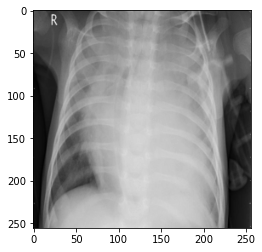

In [84]:
img, label = test_dataset[421]
plt.imshow(img[0], cmap='gray')
print('Label:', labels[label], ', Predicted:', labels[predict_image(img, model)])

In [81]:
test_dl = DeviceDataLoader(test_dl, device)


In [82]:
evaluate(model, test_dl)

{'val_loss': 0.6049951910972595, 'val_score': 0.8541666865348816}

In [90]:
!pip install jovian --upgrade

     |████████████████████████████████| 63 kB 1.1 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=158f0a9f809b3804319c254c5393de46d54b7f64b3a394754103238284c61f06
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [91]:
import jovian


<IPython.core.display.Javascript object>

In [92]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/meghanamuthukumar/Chest-XRay-Pneumonia-Project


<IPython.core.display.Javascript object>